# INTRODUCTION

## About the data

#### This dataset included:
#### - the power usage data (in kW), measured between 01/01/2010 at 1:15 and 16/02/2010 at 23:45, and 
#### - the outdoor temperature (in Celsius), measured between 01/01/2010 at 1:15 and 17/02/2010 at 23:45.
#### Both variables were measured every 15 minutes, therefore, 96 times a day (24 hours * 4 measurements per hour).
#### In the Excel sheet there were three columns, one for the timestamp, one for the power, and one for the temperature.

## About the analysis

#### The goal of this time series analysis is to forecast the power usage for 17/02/2010 first only based on the previous power time series data, and after that including the external regressor of the temperature.
#### Therefore, we will use a time series analysis with an external regressor, and NOT a multivariate time series analysis, as the relationship between power and outdoor temperature is clearly unidirectional - outdoor temperature probably affects the power usage, but the power usage does not affect outdoor temperature. 

# 1. EXPLORATORY DATA ANALYSIS

## 1.1. Data preprocessing

### Loading and observing the data

In [3]:
library('forecast')
library('xts')
library('ggplot2')
library('tseries')
library('zoo')
library('TSstudio')
library('xlsx')

#### This excel sheet included three columns: Timestamp, Power (kW) and Temperature (C)

In [4]:
data = read.csv('Elec-train.csv', skip = 1, header = F)
head(data)
tail(data)

V1,V2,V3
1/1/2010 1:15,165.1,10.6
1/1/2010 1:30,151.6,10.6
1/1/2010 1:45,146.9,10.6
1/1/2010 2:00,153.7,10.6
1/1/2010 2:15,153.8,10.6
1/1/2010 2:30,159.0,10.6


,V1,V2,V3
4598,2/17/2010 22:30,NA,13.9
4599,2/17/2010 22:45,NA,13.9
4600,2/17/2010 23:00,NA,13.9
4601,2/17/2010 23:15,NA,12.8
4602,2/17/2010 23:30,NA,12.8
4603,2/17/2010 23:45,NA,12.8


In [5]:
# checking the structure of the dataframe data
str(data)

'data.frame':	4603 obs. of  3 variables:
 $ V1: Factor w/ 4603 levels "1/1/2010 1:15",..: 1 2 3 44 45 46 47 64 65 66 ...
 $ V2: num  165 152 147 154 154 ...
 $ V3: num  10.6 10.6 10.6 10.6 10.6 10.6 10.6 10.6 10 10 ...


In [6]:
# checking the type of the timestamp variable V1, power V2 and temperature V3
typeof(data$V1)
typeof(data$V2)
typeof(data$V3)

[1] "integer"

[1] "double"

[1] "double"

#### For different purposes, we will create both a 'xts' time series with rows of power and temperature indexed by the timestamp, and the 'ts' objects for daily power usage, weekly power usage and daily temperature fluctuations.
#### As the timestamp column V1 is an integer of a 'factor' class, we will first convert it to the date and time format of a 'POSIXct' class. We see that columns V2 and V3 are doubles of a 'num' class, so there is no need to transform them.


### Converting V1 to a date and time format

In [7]:
# converting 
timestamp = strptime(data$V1, format = '%m/%d/%Y %H:%M')

In [8]:
class(timestamp)

[1] "POSIXlt" "POSIXt"

### Making the dataframe with rows indexed by the timestamp and converting it to a 'xts' time series object

In [9]:
elec_consum_df <- data.frame("Power" = data$V2, "Temperature" = data$V3)
rownames(elec_consum_df) = timestamp
head(elec_consum_df)
tail(elec_consum_df)

,Power,Temperature
2010-01-01 01:15:00,165.1,10.6
2010-01-01 01:30:00,151.6,10.6
2010-01-01 01:45:00,146.9,10.6
2010-01-01 02:00:00,153.7,10.6
2010-01-01 02:15:00,153.8,10.6
2010-01-01 02:30:00,159.0,10.6


,Power,Temperature
2010-02-17 22:30:00,NA,13.9
2010-02-17 22:45:00,NA,13.9
2010-02-17 23:00:00,NA,13.9
2010-02-17 23:15:00,NA,12.8
2010-02-17 23:30:00,NA,12.8
2010-02-17 23:45:00,NA,12.8


In [10]:
# checking the structure of the dataframe elec_consum_df
str(elec_consum_df)

'data.frame':	4603 obs. of  2 variables:
 $ Power      : num  165 152 147 154 154 ...
 $ Temperature: num  10.6 10.6 10.6 10.6 10.6 10.6 10.6 10.6 10 10 ...


In [11]:
# converting to a 'xts' object
elec_consum = as.xts(elec_consum_df)

In [12]:
str(elec_consum)

An 'xts' object on 2010-01-01 01:15:00/2010-02-17 23:45:00 containing:
  Data: num [1:4603, 1:2] 165 152 147 154 154 ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "Power" "Temperature"
  Indexed by objects of class: [POSIXct,POSIXt] TZ: 
  xts Attributes:  
 NULL


In [13]:
head(elec_consum)
tail(elec_consum)

                    Power Temperature
2010-01-01 01:15:00 165.1        10.6
2010-01-01 01:30:00 151.6        10.6
2010-01-01 01:45:00 146.9        10.6
2010-01-01 02:00:00 153.7        10.6
2010-01-01 02:15:00 153.8        10.6
2010-01-01 02:30:00 159.0        10.6

                    Power Temperature
2010-02-17 22:30:00    NA        13.9
2010-02-17 22:45:00    NA        13.9
2010-02-17 23:00:00    NA        13.9
2010-02-17 23:15:00    NA        12.8
2010-02-17 23:30:00    NA        12.8
2010-02-17 23:45:00    NA        12.8

### Making ts objects for daily and weekly power consumption, as well as for daily temperature

In [14]:
power_ts_daily = ts(data$V2[1:4507], start = 5, frequency = 96)
# start = 5 as the first unit was measured at 1:15, which is 5 * 15 minutes
length(power_ts_daily)

[1] 4507

In [15]:
power_ts_weekly = ts(data$V2[1:4507], start = 389, frequency = 672) 
# start = 389 for Friday (4*96 measurements for first four days in a week + 5 as it was at 1:15)

In [16]:
temp_ts_daily = ts(data$V3, start = 5, frequency = 96)

## 1.2. Time series plots and stationarity testing

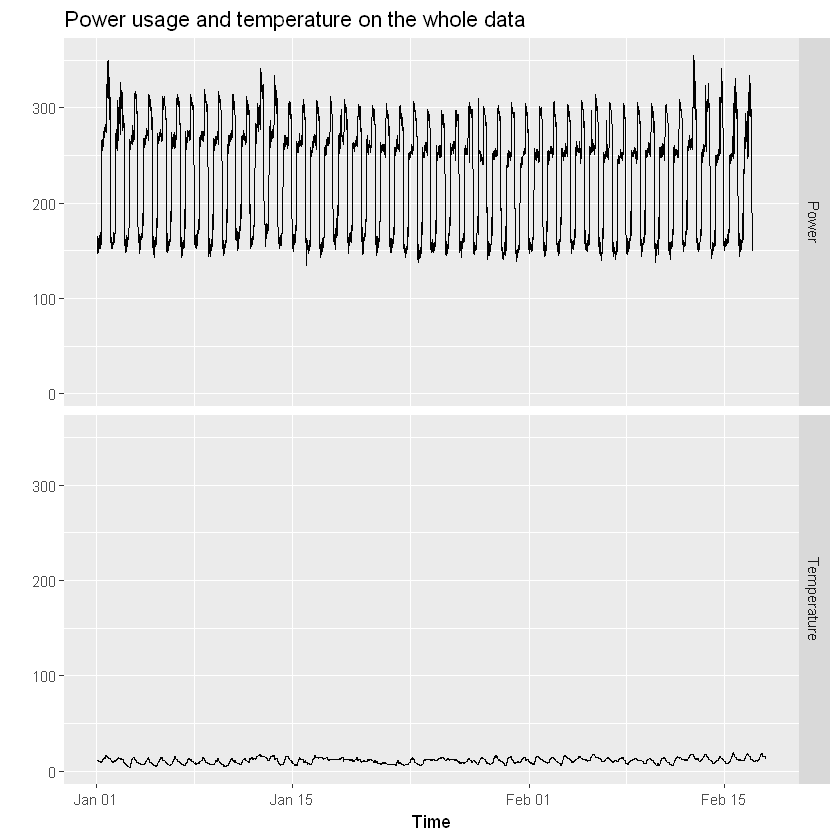

In [17]:
autoplot(elec_consum) + ggtitle('Power usage and temperature on the whole data') + xlab('Time')

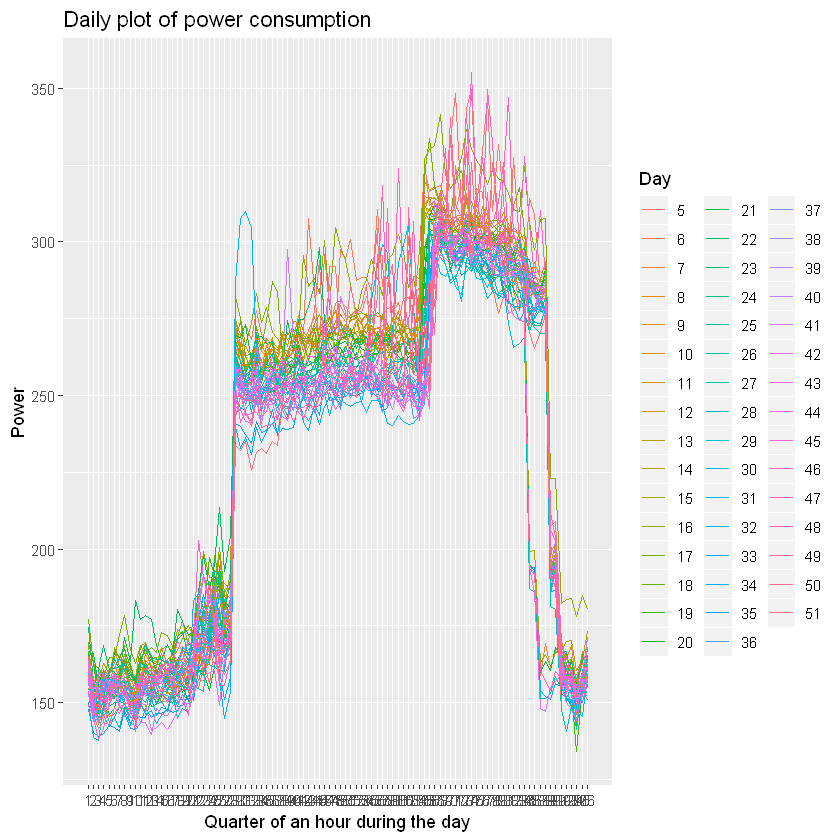

In [18]:
ggseasonplot(power_ts_daily, main = 'Daily plot of power consumption') + 
xlab('Quarter of an hour during the day') + ylab('Power') + labs(color = 'Day')

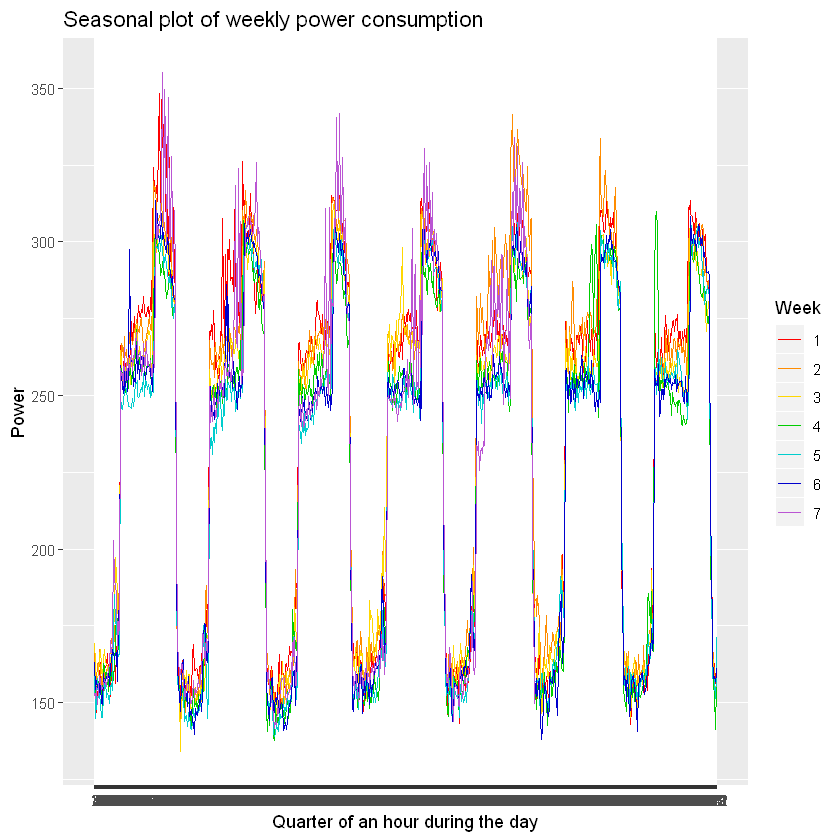

In [19]:
ggseasonplot(power_ts_weekly, main = 'Seasonal plot of weekly power consumption') + 
xlab('Quarter of an hour during the day') + ylab('Power') + labs(color = 'Week') +
scale_color_manual(labels = c("1", "2", '3', '4', '5', '6', '7'), values = c("red", "darkorange", 'gold', 'green3', 'cyan3', 'mediumblue', 'mediumorchid'))

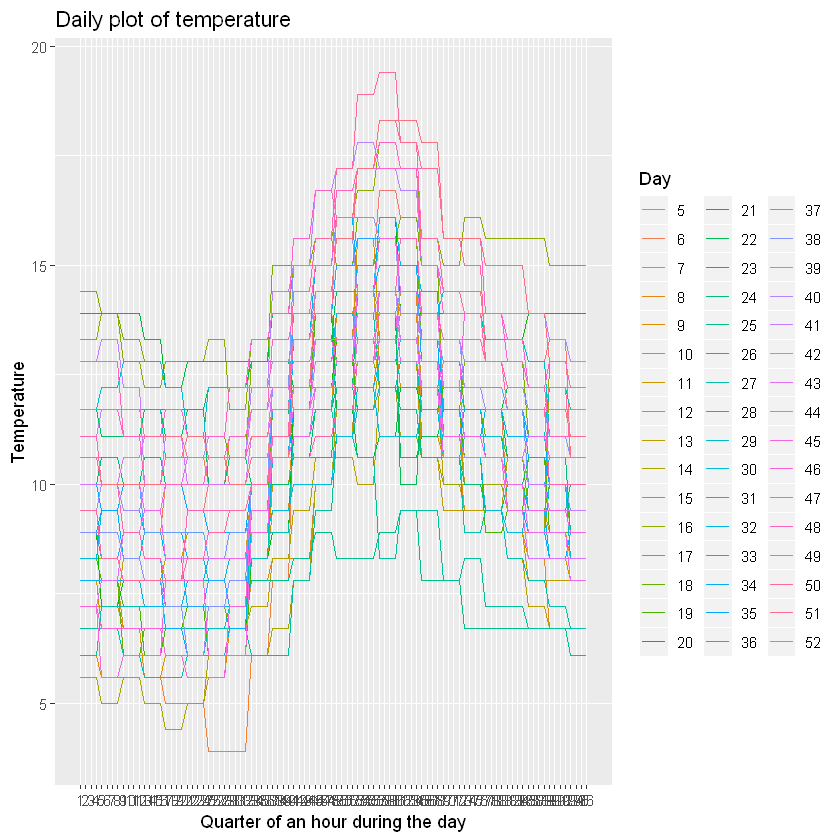

In [20]:
ggseasonplot(temp_ts_daily, main = 'Daily plot of temperature') + 
xlab('Quarter of an hour during the day') + ylab('Temperature') + labs(color = 'Day')

### Interpretation of the plots:
#### MEAN remains constant along the time both for power and for temperature.
#### VARIANCE along the time remains mostly constant for both measures.
#### The data does not follow any TREND along the time for both measures.
#### Strong daily SEASONALITY of the power, and no weekly seasonality. Mostly a daily seasonality in temperature along the time.
#### Power and temperature seem to follow the same daily pattern of increasing around the morning towards the middle of the daylight, and then decreasing towards and, again, after midnight, until the morning.

# 2. CONFIRMATORY DATA ANALYSIS

## Identification

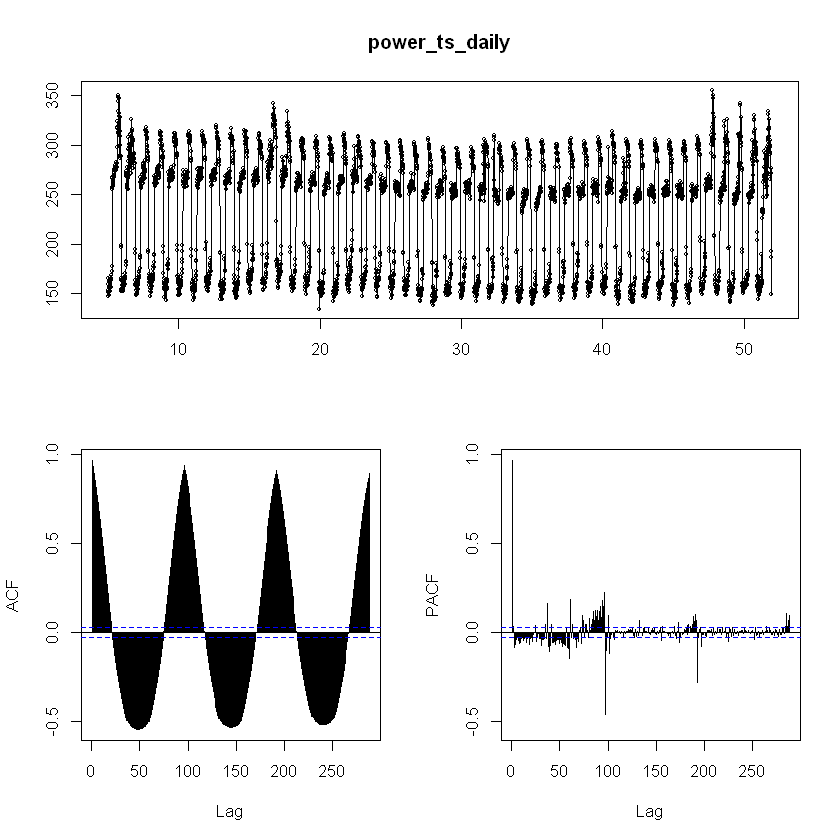

In [21]:
tsdisplay(power_ts_daily)

### Interpretation of the plots for power:
#### With the first power_ts_daily plot we can see that the power time series looks stationary, i.e. the statistical properties do not change over time, as the pulse of the dataset remains pretty much the same over time. 
#### On the autocorrelation (ACF) plot, we can see many lags represented with the vertical bars are outside of the horizontal dotted treshold line, which implies strong autocorrelation present in the daily power time series. 
#### On the partial autocorrelation (PACF) plot, although very dense, we can see that the first few (three or four) lags have significant partial autocorrelations (vertical bars outside of the horizontal dotted line). This implies that this is going to be an AR model (including the autoregressive component).
#### From these graphs we can not say for sure if the model should include the MA component or not, although it seems that PACF decreases much faster than ACF. However, this should be further investigated.

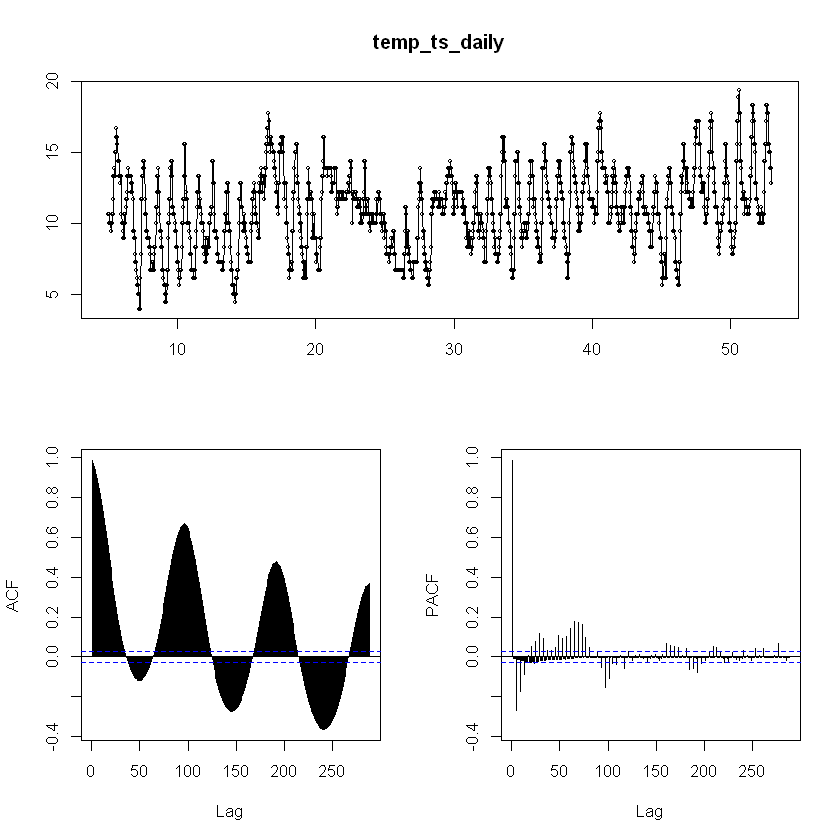

In [22]:
tsdisplay(temp_ts_daily)

### Interpretation of the plots for temperature:
#### With the first plot we confirm again that the temperature time series looks stationary.
#### ACF plot: highly autocorrelated time series. 
#### PACF plot: first four autocorrelations significant, and therefore the model will have AR component of order at least 3.
#### From these graphs it looks like the model should include the MA component, as PACF decreases much faster than ACF.

### Testing stationarity using the Augmented Dickey-Fuller test

In [23]:
adf.test(power_ts_daily)

Warning message in adf.test(power_ts_daily):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  power_ts_daily
Dickey-Fuller = -14.169, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


In [24]:
adf.test(temp_ts_daily)

Warning message in adf.test(temp_ts_daily):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  temp_ts_daily
Dickey-Fuller = -11.288, Lag order = 16, p-value = 0.01
alternative hypothesis: stationary


#### For both measures, power and temperature, we reject the null hypothesis that the data is non-stationary (p < .05), and classify both time series as STATIONARY. We can expect the same statistical properties (mean, variance, autocorrelation) for all the days along the time. Therefore, none of these two time series require differencing.

## Seasonal decomposition

#### Furthermore, to reconfirm the absence of trend graphically, we will decompose both power and temperature time series.
#### Both time series appear to have constant seasonality, which will be confirmed by R automatically choosing to perform additive decomposition of both time series (although we could also set decomposition manually to 'additive' or 'multiplicative' with the 'type' argument).

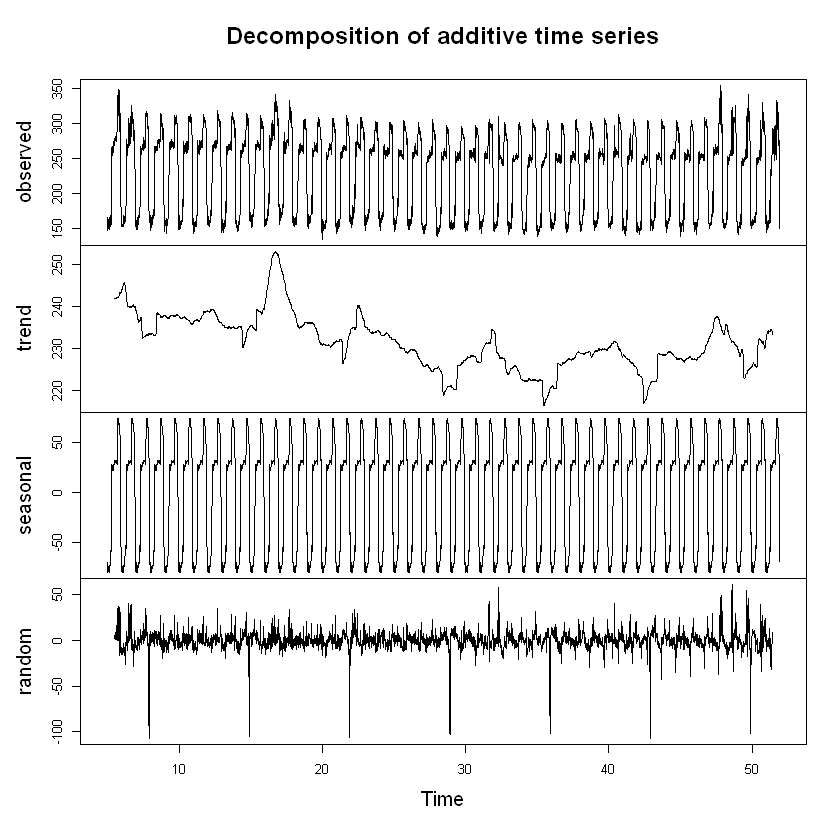

In [25]:
plot(decompose(power_ts_daily))

#### The plot above shows variations in the trend curve, and therefore there is no clear trend in the power time series.
#### Additionally, we can detect seasonality in the random component (i.e. the random component is not really random), which confirms that decomposition would not be an appropriate model for the power time series.

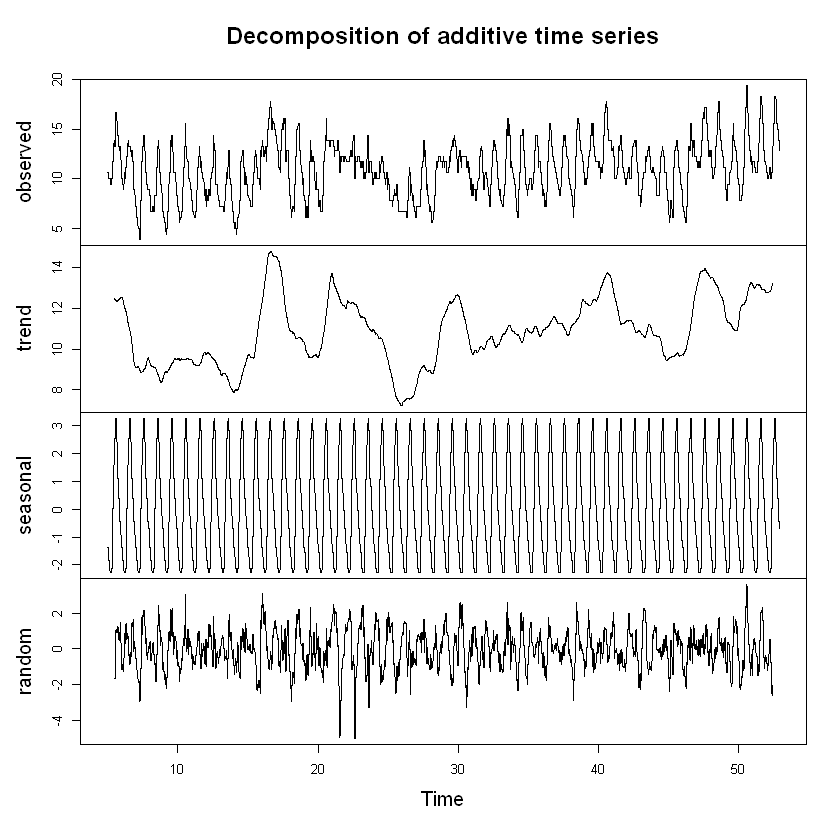

In [26]:
plot(decompose(temp_ts_daily))

#### The temperature seasonal decomposition plot also presents variations of the trend component, and hence temperature also does not have any trend.

# 3. UNIVARIATE TIME SERIES ANALYSIS OF POWER CONSUMPTION

## 3.1. CHOICE OF MODEL

## Parameter estimation

#### First we will make a training and test subset, with the test being of a length of ten day's measurements (around 80% of the data).

In [28]:
split_power <- ts_split(ts.obj = power_ts_daily, sample.out = 960)

power_ts_train <- split_power$train
power_ts_test <- split_power$test

sprintf('The total length of the power time series: %d', length(power_ts_daily))
sprintf('The length of the power training time series: %d', length(power_ts_train))
sprintf('The length of the power test time series: %d', length(power_ts_test))

[1] "The total length of the power time series: 4507"

[1] "The length of the power training time series: 3547"

[1] "The length of the power test time series: 960"

### ARIMA models
#### The parameters will first be estimated using the auto.arima() function on the training set of power time series, which will indicate the orders of autoregressive, differencing and moving average component of the time series. This function was used with stepwise = FALSE for going over all possible models for selection.

In [29]:
auto.arima(power_ts_train, trace = TRUE, stepwise = FALSE)


 Fitting models using approximations to speed things up...

 ARIMA(0,0,0)(0,1,0)[96]                    : 28119.5
 ARIMA(0,0,0)(0,1,0)[96] with drift         : 28118.99
 ARIMA(0,0,0)(0,1,1)[96]                    : Inf
 ARIMA(0,0,0)(0,1,1)[96] with drift         : Inf
 ARIMA(0,0,0)(0,1,2)[96]                    : Inf
 ARIMA(0,0,0)(0,1,2)[96] with drift         : Inf
 ARIMA(0,0,0)(1,1,0)[96]                    : Inf
 ARIMA(0,0,0)(1,1,0)[96] with drift         : Inf
 ARIMA(0,0,0)(1,1,1)[96]                    : Inf
 ARIMA(0,0,0)(1,1,1)[96] with drift         : Inf
 ARIMA(0,0,0)(1,1,2)[96]                    : Inf
 ARIMA(0,0,0)(1,1,2)[96] with drift         : Inf
 ARIMA(0,0,0)(2,1,0)[96]                    : Inf
 ARIMA(0,0,0)(2,1,0)[96] with drift         : Inf
 ARIMA(0,0,0)(2,1,1)[96]                    : Inf
 ARIMA(0,0,0)(2,1,1)[96] with drift         : Inf
 ARIMA(0,0,0)(2,1,2)[96]                    : Inf
 ARIMA(0,0,0)(2,1,2)[96] with drift         : Inf
 ARIMA(0,0,1)(0,1,0)[96]      

Series: power_ts_train 
ARIMA(1,0,4)(0,1,0)[96] 

Coefficients:
         ar1      ma1     ma2     ma3      ma4
      0.8383  -0.0715  0.0451  0.0123  -0.2588
s.e.  0.0348   0.0405  0.0336  0.0310   0.0277

sigma^2 estimated as 90.77:  log likelihood=-12673.88
AIC=25359.76   AICc=25359.79   BIC=25396.64

#### The best model was chosen automatically using The Akaike information criterion (AIC).
#### This recommended model is the model with the autoregressive component of order 1, and the absence of differencing, and the moving average component of order 4. The model also indicates the presence of the seasonal components, as we have assumed when plotting ACF and PACF. Specifically, it includes the seasonal differencing component.
#### To conclude, the best model on the training subset chosen by auto.arma() function is the ARMA model with seasonal differencing.

### Seasonal and trend decomposition using Loess

In [30]:
stlf(power_ts_train, h = 960)

         Point Forecast       Lo 80    Hi 80        Lo 95    Hi 95
41.94792       153.8713 145.2483174 162.4943  140.6835945 167.0590
41.95833       153.2922 142.0890176 164.4954  136.1584140 170.4260
41.96875       148.7884 135.4968209 162.0800  128.4606698 169.1162
41.97917       154.2110 139.1172049 169.3048  131.1270369 177.2949
41.98958       158.3983 141.6956869 175.1010  132.8538462 183.9428
42.00000       156.5357 138.3661062 174.7053  128.7477118 184.3237
42.01042       146.6980 127.1713284 166.2246  116.8345555 176.5614
42.02083       151.0575 130.2621432 171.8528  119.2537720 182.8611
42.03125       152.7501 130.7591699 174.7410  119.1178813 186.3823
42.04167       150.6970 127.5721757 173.8218  115.3306495 186.0633
42.05208       152.8092 128.6036041 177.0148  115.7899268 189.8285
42.06250       150.4142 125.1740451 175.6544  111.8126945 189.0158
42.07292       150.1224 123.8884189 176.3564  110.0009766 190.2439
42.08333       146.9278 119.7362747 174.1193  105.3419558 188.

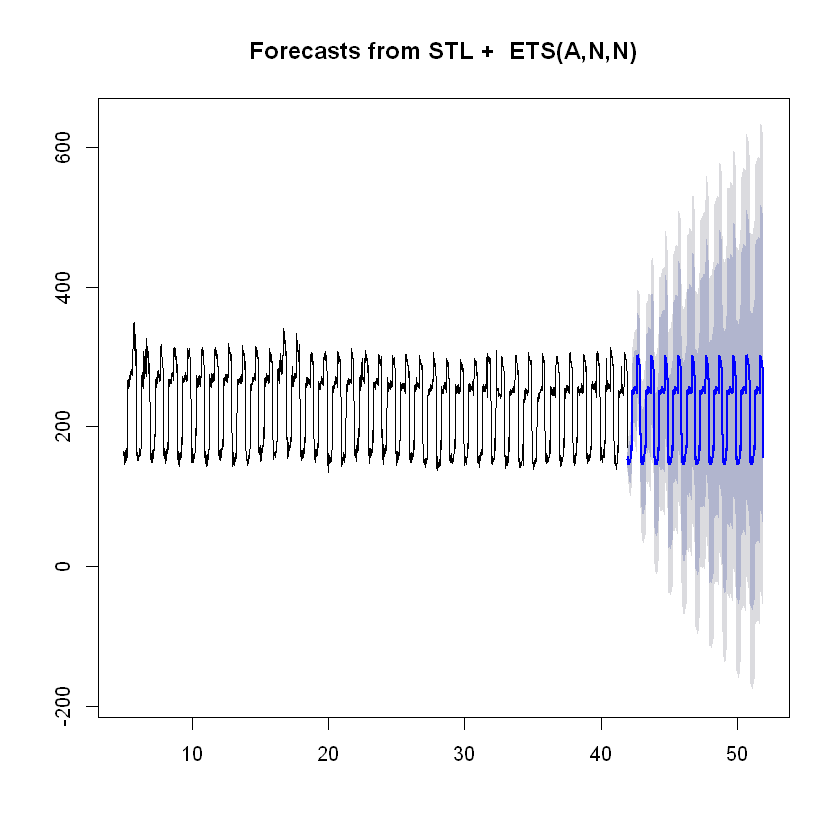

In [31]:
plot(stlf(power_ts_train, h = 960))

#### The stlf() forecasting function have chosen the model of STL with additive error, non-present seasonality, and non-present trend.

### Holt-Winters models

In [32]:
HoltWinters(power_ts_train)

Holt-Winters exponential smoothing with trend and additive seasonal component.

Call:
HoltWinters(x = power_ts_train)

Smoothing parameters:
 alpha: 0.7089052
 beta : 0
 gamma: 0.8056369

Coefficients:
             [,1]
a   221.796653834
b    -0.003384519
s1  -66.966016717
s2  -66.314827518
s3  -70.895014536
s4  -64.682283717
s5  -61.141851544
s6  -64.582384499
s7  -76.474018566
s8  -73.011363496
s9  -74.302025181
s10 -78.046345314
s11 -76.953040121
s12 -83.131545534
s13 -84.906855573
s14 -88.167830395
s15 -89.674852682
s16 -86.653869637
s17 -85.965620600
s18 -87.194137719
s19 -83.959761338
s20 -85.940608833
s21 -85.294922926
s22 -86.249702640
s23 -85.022514623
s24 -81.798652630
s25 -82.015738644
s26 -78.218124802
s27 -68.493692860
s28 -68.724355555
s29 -66.758493261
s30 -66.705351483
s31 -75.028976911
s32 -71.277297275
s33 -71.164467724
s34  11.113858752
s35  13.928589002
s36   9.703457157
s37  12.110911520
s38  15.560242469
s39  10.311421034
s40  11.866336907
s41  14.489083191
s42  1

#### The function without specifying the smoothing parameter automatically selected the exponential smoothing model with trend and additive seasonal component. Error and seasonal component were rather non-smoothed (coefficients alpha and gamma closer to 1), i.e. the model relied somewhat more on recent data regarding error and seasonality. The trend component was completely smoothed (coefficient beta equals 0), i.e. the model relied on all provided data regarding the trend.

### Neural networks model

In [33]:
set.seed(12)
power_nn = nnetar(power_ts_train, repeats = 30)
print(power_nn)

Series: power_ts_train 
Model:  NNAR(20,1,11)[96] 
Call:   nnetar(y = power_ts_train, repeats = 30)

Average of 30 networks, each of which is
a 21-11-1 network with 254 weights
options were - linear output units 

sigma^2 estimated as 47.46


#### The nnetar() function with 30 repetitions has automatically chosen the model with 20 lagged values and one seasonal lag as input, and 11 nodes in hidden layer.

### Candidate models:
##### - seasonal differencing ARMA (1,0,4)(0,1,0)[96],
##### - seasonal and trend decomposition decomposition by Loess with additive error, and
##### - Holt-Winters exponential smoothing with trend and additive seasonal component
##### - Neural networks model with a seasonal lag

#### Before choosing the right model based on lowest error terms, we will plot predictions on the training data set for 02/16/2010 for each model on the same graph, to observe how they differ among each other and from the real data for the same date.

In [34]:
power_sarma = Arima(power_ts_train, order = c(1,0,4), seasonal = list(order = c(0,1,0), period = 96))
power_sarma_list = predict(power_sarma, n.ahead = 960)

In [35]:
power_sarma_f = forecast(power_sarma, h = 960)

In [36]:
power_stlf = stlf(power_ts_train, h = 960)

In [37]:
power_hw = HoltWinters(power_ts_train)
power_hw_fp = predict(power_hw, n.ahead = 960)
power_hw_f = forecast(power_hw, h = 960)

In [38]:
power_nn_f = forecast(power_nn, h = 960)

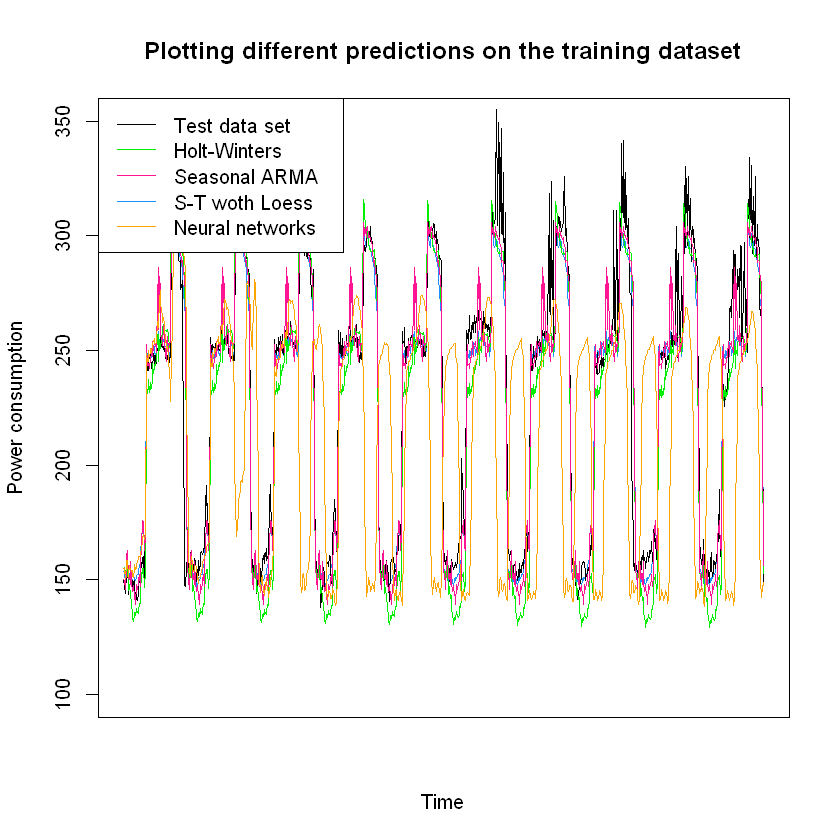

In [40]:
plot(power_stlf$mean, col = 'dodgerblue1', main = 'Plotting different predictions on the training dataset', xaxt = 'n', ylab = 'Power consumption', xlab = 'Time', ylim = c(100,350))
lines(power_ts_test)
lines(power_hw_fp, col = 'green2')
lines(power_sarma_list$pred, col = 'deeppink')
lines(power_nn_f$mean, col = 'orange')
legend('topleft', lty=1, col=c('black','green2', 'deeppink', 'dodgerblue1', 'orange'), legend=c('Test data set','Holt-Winters', 'Seasonal ARMA', 'S-T woth Loess', 'Neural networks'))

#### We can observe that the three models do not give very different predictions, and probably the closests ones to the test data are seasonal and trend decomposition with Loess, and the neural networks model.

### Choosing the model

#### The best model will be chosen based on lowest error terms.

In [41]:
accuracy(power_sarma_f, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.08360839,9.390565,5.808776,-0.1195474,2.668101,0.7280167,-0.005148572,NA
Test set,2.03614927,16.133818,9.642507,0.7965414,4.461296,1.2085001,0.643970565,1.051176


In [42]:
accuracy(power_stlf, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.004893643,6.72664,4.054505,-0.05175693,1.885304,0.5081531,0.002365153,NA
Test set,3.559910520,15.01703,8.522011,1.16926382,3.795614,1.0680678,0.665354878,0.944347


In [43]:
accuracy(power_hw_f, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.003871904,8.466331,5.314248,0.02464648,2.437608,0.6660373,0.1124541,NA
Test set,8.739645222,19.078719,13.651142,4.27854455,6.624582,1.7109043,0.7346250,1.309516


In [44]:
accuracy(power_nn_f, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,0.003001762,6.889092,4.345297,-0.118966,1.978555,0.5445981,0.1323332,NA
Test set,16.107246970,71.831641,52.900984,1.377827,24.150656,6.6301060,0.9643151,4.446267


#### We can see from the above that the lowest values on RMSE (root mean squared error), MAE (mean absolute error), MAPE (mean absolute percentage error) and MASE (mean absolute scaled error) are for seasonal and trend decomposition using Loess.

### Testing residuals of the seasonal and trend decomposition using Loess and improving the model

Warning message in checkresiduals(power_stlf):
"The fitted degrees of freedom is based on the model used for the seasonally adjusted data."


	Ljung-Box test

data:  Residuals from STL +  ETS(A,N,N)
Q* = 797.95, df = 190, p-value < 2.2e-16

Model df: 2.   Total lags used: 192



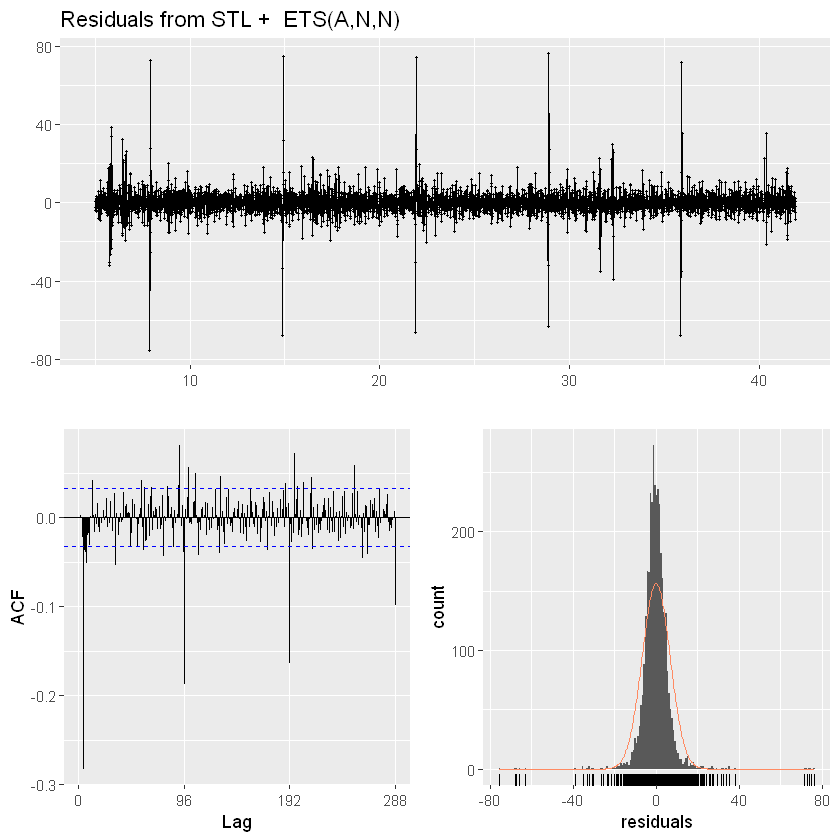

In [45]:
checkresiduals(power_stlf)

#### Residuals for the model are out of the significance limits, which means that they contain more information than just a white noise. On the ACF plot we can observe around 30 significant autocorrelations of the residuals, and the negative ones follow the seasonality of the time series (96). The Ljung-Box test shows that the residuals have some remaining autocorrelations (p < .05). 
#### Due to this, we will try to improve this function, adding parameter s.window.

Warning message in checkresiduals(power_stlf_periodic):
"The fitted degrees of freedom is based on the model used for the seasonally adjusted data."


	Ljung-Box test

data:  Residuals from STL +  ETS(A,N,N)
Q* = 514.95, df = 190, p-value < 2.2e-16

Model df: 2.   Total lags used: 192



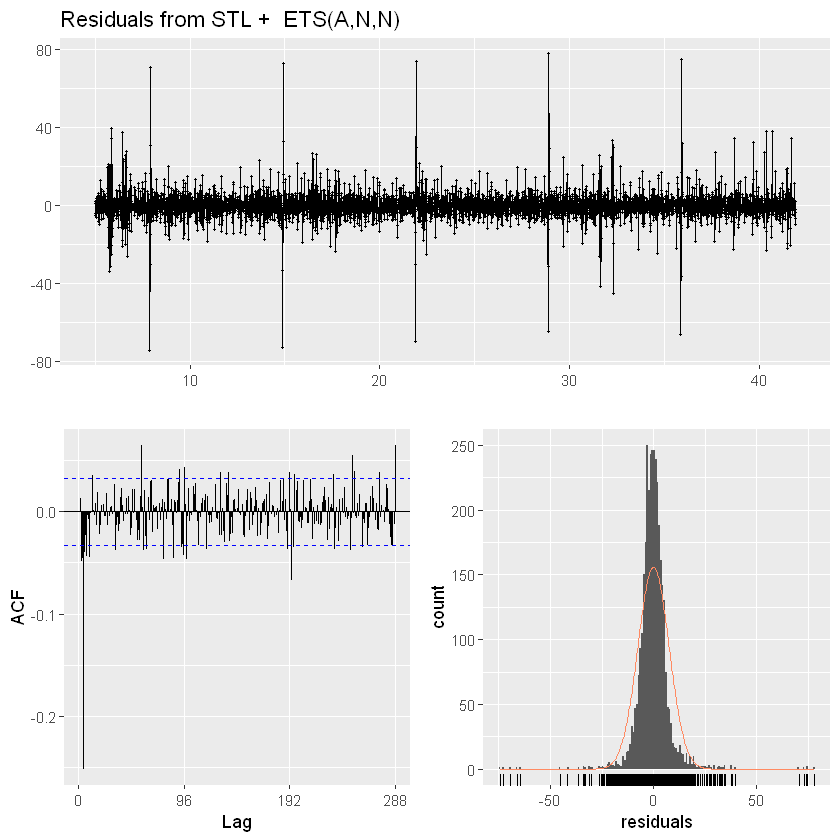

In [46]:
power_stlf_periodic = stlf(power_ts_train, h = 960, s.window = 'periodic')
checkresiduals(power_stlf_periodic)

Warning message in checkresiduals(power_stlf_sw95):
"The fitted degrees of freedom is based on the model used for the seasonally adjusted data."


	Ljung-Box test

data:  Residuals from STL +  ETS(A,N,N)
Q* = 497.1, df = 190, p-value < 2.2e-16

Model df: 2.   Total lags used: 192



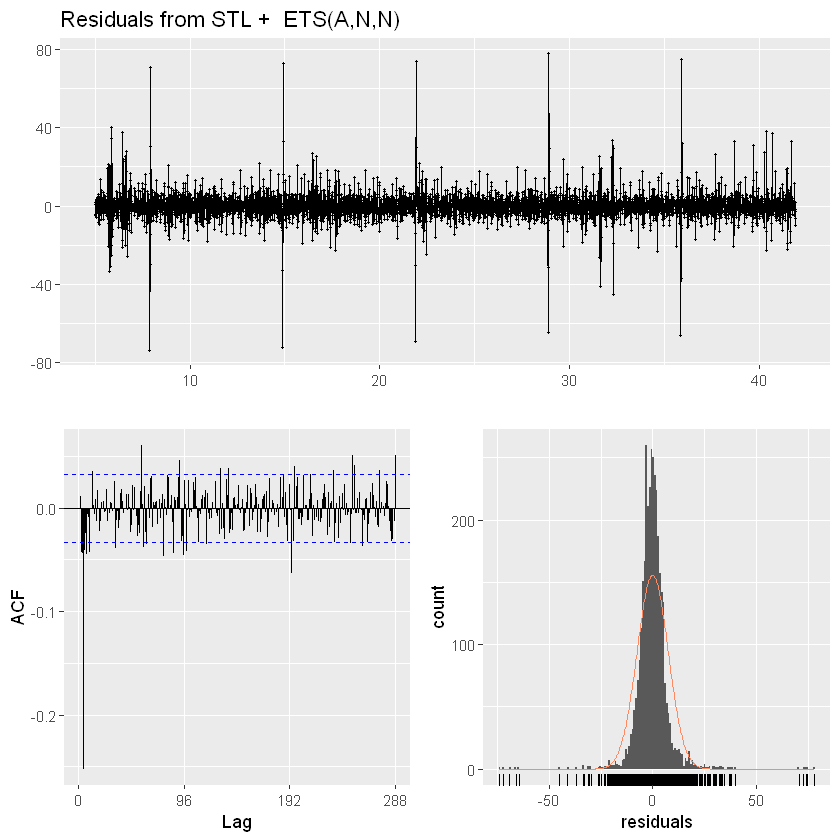

In [47]:
power_stlf_sw95 = stlf(power_ts_train, h = 960, s.window = 95)
checkresiduals(power_stlf_sw95)

Warning message in checkresiduals(power_stlf_sw61):
"The fitted degrees of freedom is based on the model used for the seasonally adjusted data."


	Ljung-Box test

data:  Residuals from STL +  ETS(A,N,N)
Q* = 483.68, df = 190, p-value < 2.2e-16

Model df: 2.   Total lags used: 192



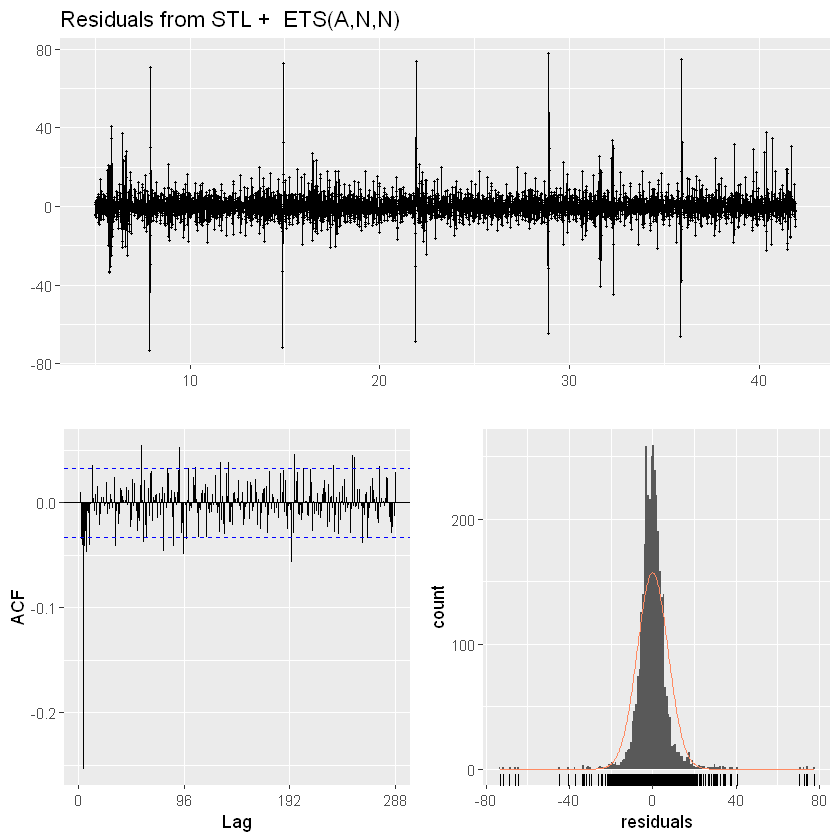

In [48]:
power_stlf_sw61 = stlf(power_ts_train, h = 960, s.window = 61)
checkresiduals(power_stlf_sw61)

#### According to the residuals testing, the lowest autocorrelation rates are for the model with s.window span of 61. All three variations of s.window parameter removed periods of autocorrelations.

In [49]:
accuracy(power_stlf_periodic, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.002657935,7.561345,4.644567,-0.06191195,2.123146,0.5821058,0.01287091,NA
Test set,1.223906361,15.242317,9.354086,0.24530914,4.135359,1.1723521,0.67620759,0.9436595


In [50]:
accuracy(power_stlf_sw95, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.0028212,7.494749,4.604747,-0.06194821,2.107243,0.5771152,0.01145563,NA
Test set,1.4903248,15.178593,9.238244,0.33816261,4.082177,1.1578336,0.67436815,0.9397374


In [51]:
accuracy(power_stlf_sw61, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.003138367,7.392284,4.541376,-0.06203065,2.082138,0.5691729,0.01018464,NA
Test set,1.860798864,15.115053,9.094592,0.46656176,4.014706,1.1398297,0.67199860,0.935399


In [52]:
accuracy(power_stlf, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.004893643,6.72664,4.054505,-0.05175693,1.885304,0.5081531,0.002365153,NA
Test set,3.559910520,15.01703,8.522011,1.16926382,3.795614,1.0680678,0.665354878,0.944347


#### All four models have similar gaps between training and test sets, therefore there was some overfitting of these models.
#### The lowest error rates are still for the default model, and they are lower for the model with span of 61 than for the other two manually adjusted models.
#### The final decision is to use the seasonal and trend decomposition by Loess model with s.window = 61 for forecasting the power consumption for 02/17/2010.

## 3.2. FORECASTING THE POWER CONSUMPTION

In [53]:
power_stlf_forecast = stlf(power_ts_daily, h = 96, s.window = 61)

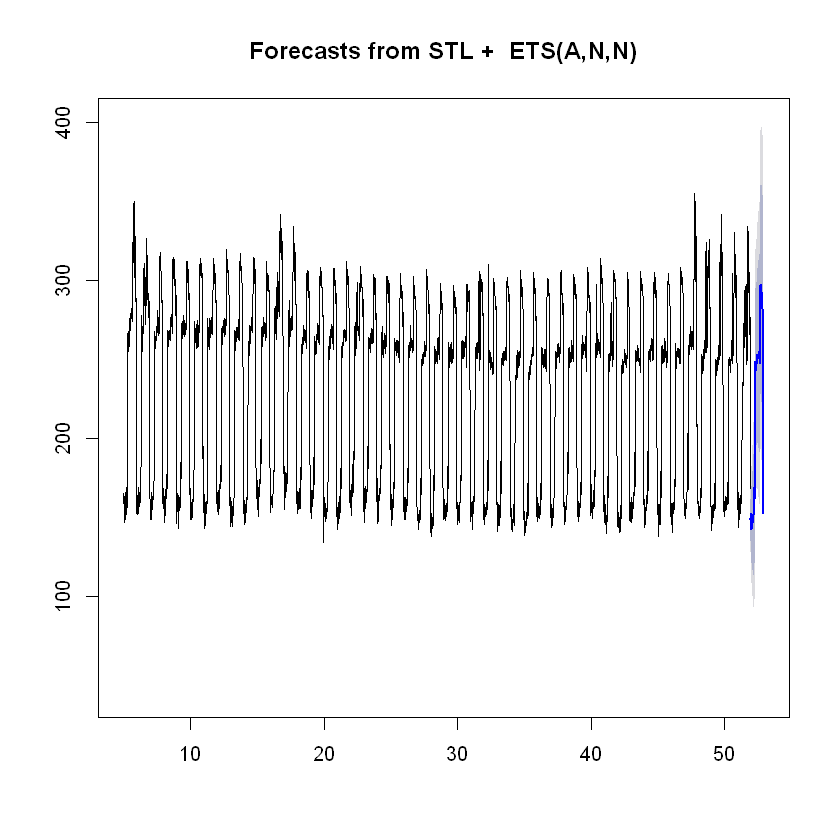

In [54]:
plot(power_stlf_forecast)

# 4. ADDING EXTERNAL REGRESSOR OUTDOOR TEMPERATURE

## 4.1. CHOICE OF MODEL

## Parameter estimation

In [55]:
split_power <- ts_split(ts.obj = temp_ts_daily, sample.out = 96)
temp_ts_till_02_17 <- split_power$train
temp_ts_02_17 <- split_power$test

split_power <- ts_split(ts.obj = temp_ts_till_02_17, sample.out = 960)
temp_ts_train <- split_power$train
temp_ts_test <- split_power$test

### ARIMAX models

In [56]:
auto.arima(power_ts_train, xreg = temp_ts_train, trace = TRUE, stepwise = FALSE)


 Fitting models using approximations to speed things up...

 ARIMA(0,0,0)(0,1,0)[96]                    : 28082.94
 Regression with ARIMA(0,0,0)(0,1,0)[96] errors : 28082.59
 ARIMA(0,0,0)(0,1,1)[96]                    : Inf
 Regression with ARIMA(0,0,0)(0,1,1)[96] errors : Inf
 ARIMA(0,0,0)(0,1,2)[96]                    : Inf
 Regression with ARIMA(0,0,0)(0,1,2)[96] errors : Inf
 ARIMA(0,0,0)(1,1,0)[96]                    : Inf
 Regression with ARIMA(0,0,0)(1,1,0)[96] errors : Inf
 ARIMA(0,0,0)(1,1,1)[96]                    : Inf
 Regression with ARIMA(0,0,0)(1,1,1)[96] errors : Inf
 ARIMA(0,0,0)(1,1,2)[96]                    : Inf
 Regression with ARIMA(0,0,0)(1,1,2)[96] errors : Inf
 ARIMA(0,0,0)(2,1,0)[96]                    : Inf
 Regression with ARIMA(0,0,0)(2,1,0)[96] errors : Inf
 ARIMA(0,0,0)(2,1,1)[96]                    : Inf
 Regression with ARIMA(0,0,0)(2,1,1)[96] errors : Inf
 ARIMA(0,0,0)(2,1,2)[96]                    : Inf
 Regression with ARIMA(0,0,0)(2,1,2)[96] errors

Series: power_ts_train 
Regression with ARIMA(1,0,4)(0,1,0)[96] errors 

Coefficients:
         ar1      ma1     ma2     ma3      ma4    xreg
      0.8319  -0.0656  0.0499  0.0163  -0.2554  0.1747
s.e.  0.0364   0.0418  0.0344  0.0316   0.0281  0.2407

sigma^2 estimated as 90.78:  log likelihood=-12673.61
AIC=25361.22   AICc=25361.25   BIC=25404.24

In [57]:
power_sarma_xreg = Arima(power_ts_train, order = c(1,0,4), seasonal = list(order = c(0,1,0), period = 96), xreg = temp_ts_train)
power_sarma_xreg_f = forecast(power_sarma_xreg, h = 960, xreg = temp_ts_test)

### Neural networks model with an external regressor

In [58]:
set.seed(5)
power_nn_xreg = nnetar(power_ts_train, xreg = temp_ts_train, repeats = 30)
print(power_nn_xreg)

Series: power_ts_train 
Model:  NNAR(20,1,12)[96] 
Call:   nnetar(y = power_ts_train, repeats = 30, xreg = temp_ts_train)

Average of 30 networks, each of which is
a 22-12-1 network with 289 weights
options were - linear output units 

sigma^2 estimated as 47.9


#### The nnetar() function with 30 repetitions has automatically chosen the model with 11 lagged values and one seasonal lag as input, and 7 nodes in hidden layer.

In [59]:
power_nn_xreg_f = forecast(power_nn_xreg, h = 960, xreg = temp_ts_test)

#### Plotting predictions of the different models:
##### - seasonal ARMAX
##### - NN model with an external regressor

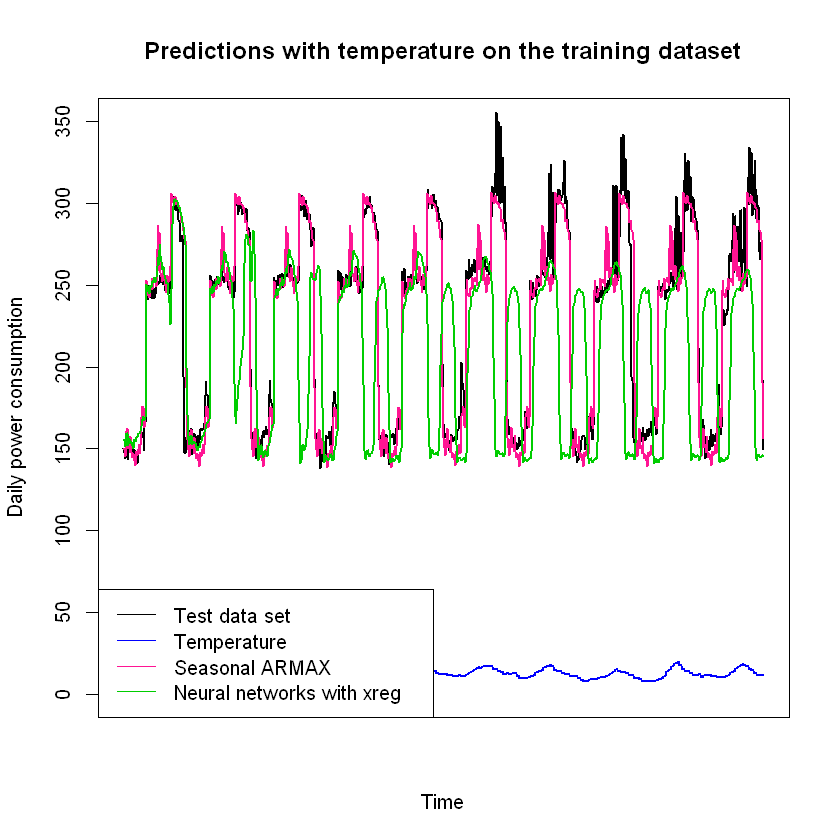

In [61]:
plot(temp_ts_test, col = 'blue', lwd = 2, main = 'Predictions with temperature on the training dataset', xaxt = 'n', ylab = 'Daily power consumption', xlab = 'Time', ylim = c(0,350))
lines(power_ts_test, lwd = 2)
lines(power_sarma_xreg_f$mean, col = 'deeppink', lwd = 2)
lines(power_nn_xreg_f$mean, col = 'green3', lwd = 2)
legend('bottomleft', lty=1, col=c('black', 'blue', 'deeppink', 'green3'), legend=c('Test data set', 'Temperature', 'Seasonal ARMAX', 'Neural networks with xreg'))

#### Seasonal ARMAX seems to correspond to the test data set slightly better than the neural networks model.

### Choosing the model

In [62]:
accuracy(power_sarma_xreg_f, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.08400564,9.389831,5.806149,-0.1201290,2.666319,0.7276875,-0.005472531,NA
Test set,2.01271322,16.080110,9.618255,0.8124432,4.463167,1.2054606,0.641458747,1.050971


In [63]:
accuracy(power_nn_xreg_f, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.00208728,6.921312,4.366629,-0.1176867,1.987075,0.5472717,0.1258850,NA
Test set,18.48353059,70.512607,48.758856,2.8646054,21.711105,6.1109711,0.9638244,4.159398


#### Due to lower error rates, the neural networks model was chosen for prediction of power with temperature as an external regressor.

### Testing residuals of the neural networks model with an external regressor

Warning message in modeldf.default(object):
"Could not find appropriate degrees of freedom for this model."

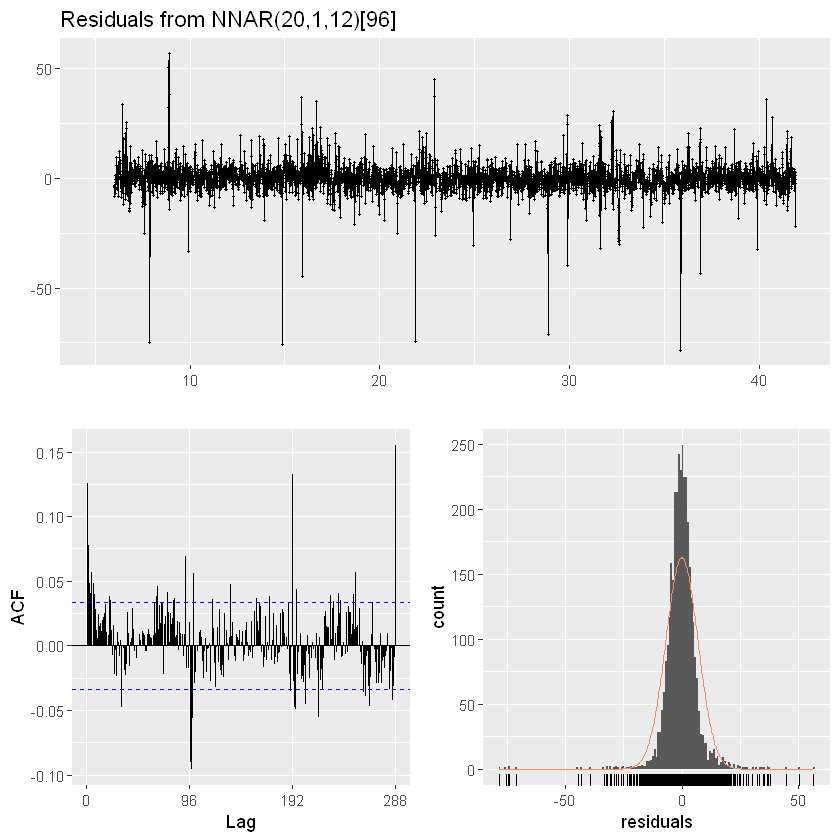

In [64]:
checkresiduals(power_nn_xreg_f)

#### Due to the autocorrelated residuals, this is not an ideal model, however, it is the best possible after choosing the most suitable models with auto.arima and neural networks. Distribution of residuals is symmetric, but thinner and higher and normal, and the largest autocorrelations are at the periods of 96, which means that residuals do not include only randomness.

### 4.2 FORECASTING THE POWER CONSUMPTION WITH TEMPERATURE AS AN EXTERNAL REGRESSOR

In [65]:
set.seed(5)
power_nn_xreg_model = nnetar(power_ts_daily, xreg = temp_ts_till_02_17, repeats = 30)
print(power_nn_xreg_model)

Series: power_ts_daily 
Model:  NNAR(11,1,7)[96] 
Call:   nnetar(y = power_ts_daily, repeats = 30, xreg = temp_ts_till_02_17)

Average of 30 networks, each of which is
a 13-7-1 network with 106 weights
options were - linear output units 

sigma^2 estimated as 76.86


In [66]:
power_nn_xreg_forecast = forecast(power_nn_xreg_model, h = 96, xreg = temp_ts_02_17)

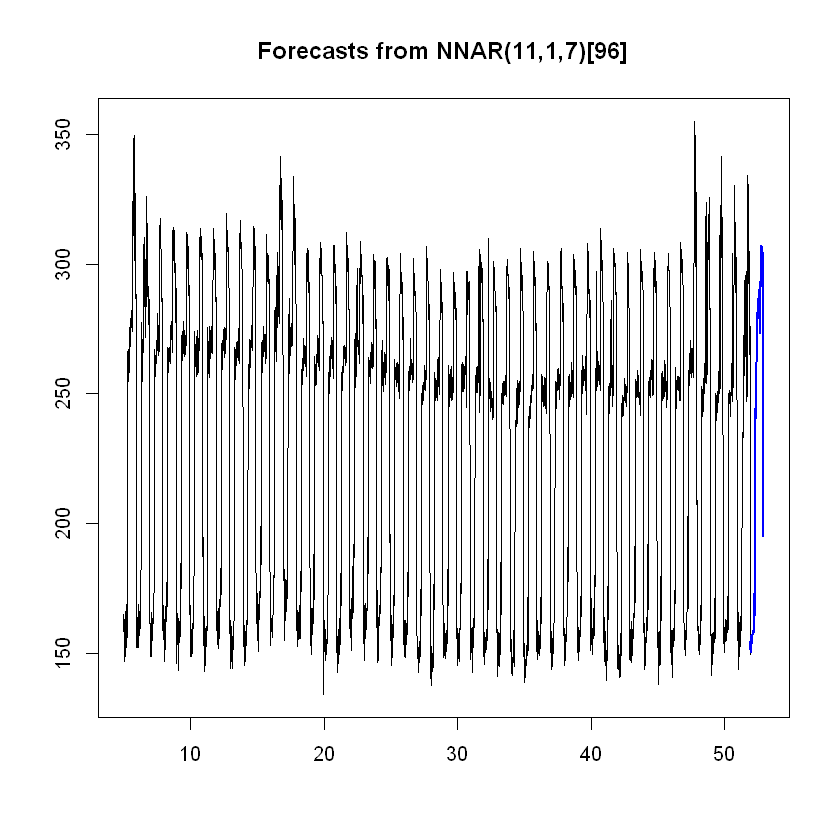

In [67]:
plot(power_nn_xreg_forecast)

# Comparing univariate forecast and forecast with external regressor outdoor temperature

In [68]:
accuracy(power_stlf, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.004893643,6.72664,4.054505,-0.05175693,1.885304,0.5081531,0.002365153,NA
Test set,3.559910520,15.01703,8.522011,1.16926382,3.795614,1.0680678,0.665354878,0.944347


In [69]:
accuracy(power_nn_xreg_f, power_ts_test)

,ME,RMSE,MAE,MPE,MAPE,MASE,ACF1,Theil's U
Training set,-0.00208728,6.921312,4.366629,-0.1176867,1.987075,0.5472717,0.1258850,NA
Test set,18.48353059,70.512607,48.758856,2.8646054,21.711105,6.1109711,0.9638244,4.159398


#### The error rate is lower with the best model we have obtained for univariate prediction, than with including external regressor outdoor temperature.

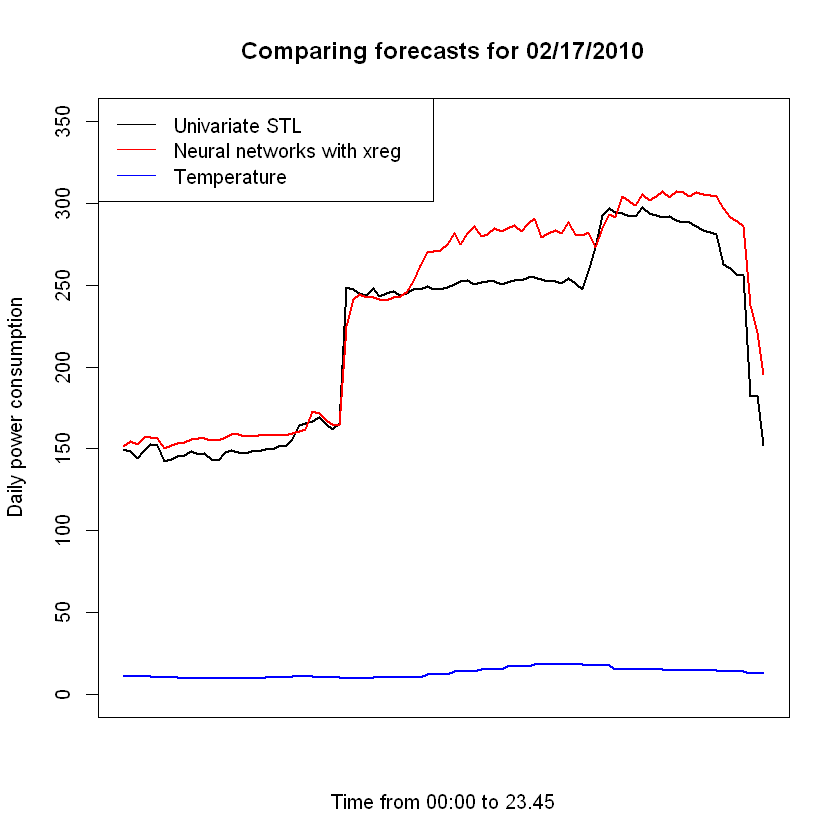

In [70]:
plot(power_stlf_forecast$mean, col = 'black', lwd = 2, main = 'Comparing forecasts for 02/17/2010', xaxt = 'n', ylab = 'Daily power consumption', xlab = 'Time from 00:00 to 23.45', ylim = c(0,350))
lines(power_nn_xreg_forecast$mean, col = 'red', lwd = 2)
lines(temp_ts_02_17, col = 'blue', lwd = 2)
legend('topleft', lty=1, col=c('black', 'red', 'blue'), legend=c('Univariate STL' ,'Neural networks with xreg', 'Temperature'))

#### The forecast model of neural networks with external regressor seems to follow the temperature values on the graph above, than the univariate STL model, as expected. 

In [71]:
summary(power_stlf_forecast$mean)
summary(power_nn_xreg_forecast$mean)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  142.6   152.2   247.3   221.9   255.0   297.3 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  150.3   158.7   265.9   236.4   286.2   307.1 

In [72]:
t.test(power_stlf_forecast$mean, power_nn_xreg_forecast$mean, paired = TRUE, alternative = 'two.sided')


	Paired t-test

data:  power_stlf_forecast$mean and power_nn_xreg_forecast$mean
t = -10.082, df = 95, p-value < 2.2e-16
alternative hypothesis: true difference in means is not equal to 0
95 percent confidence interval:
 -17.40106 -11.67539
sample estimates:
mean of the differences 
              -14.53823 


#### According to the paired-samples t-test, the forecast of neural networks with external regressor was, on average, predicting higher power consumption, than the univariate STL forecast.

In [81]:
cor.test(power_stlf_forecast$mean, power_nn_xreg_forecast$mean)


	Pearson's product-moment correlation

data:  power_stlf_forecast$mean and power_nn_xreg_forecast$mean
t = 41.537, df = 94, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.9609522 0.9824903
sample estimates:
      cor 
0.9738238 


#### Correlation between the two predictions was almost 1. 

### **** Writing forecasts in .xlsx ****

In [82]:
forecast_df = data.frame(Univariate = as.matrix(power_stlf_forecast$mean), With_temperature = as.matrix(power_nn_xreg_forecast$mean))

In [83]:
head(forecast_df)
str(forecast_df)

Univariate,With_temperature
149.5075,151.5130
148.6357,154.6141
143.9241,152.5232
148.9184,156.7648
152.4286,156.9105
151.8631,156.3698


'data.frame':	96 obs. of  2 variables:
 $ Univariate      : num  150 149 144 149 152 ...
 $ With_temperature: num  152 155 153 157 157 ...


In [85]:
# writing the second prediction in the workbook
write.xlsx(forecast_df, file = "Power consumption forecast.xlsx", sheetName = "Sheet 1", row.names = FALSE, col.names = TRUE, append = FALSE)